# EMOTION ANALYSIS

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/03-emotion-analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/03-emotion-analysis.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/03-emotion-analysis.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB

In [1]:
%pip install --quiet "evadb[vision,notebook]"
%pip install --quiet facenet_pytorch
import evadb
cursor = evadb.connect().cursor()
import warnings
warnings.filterwarnings("ignore")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.6

Downloading: "http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth" to /root/.cache/torch/hub/checkpoints/mnist-b07bb66b.pth
100%|██████████| 1.03M/1.03M [00:01<00:00, 1.02MB/s]
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 246MB/s]


### Download Video

In [2]:
# A video of a happy person
!wget -nc "https://www.dropbox.com/s/gzfhwmib7u804zy/defhappy.mp4?raw=1" -O defhappy.mp4

# Adding Emotion detection
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/functions/emotion_detector.py

# Adding Face Detector
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/functions/face_detector.py

--2023-10-11 05:24:07--  https://www.dropbox.com/s/gzfhwmib7u804zy/defhappy.mp4?raw=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/gzfhwmib7u804zy/defhappy.mp4 [following]
--2023-10-11 05:24:07--  https://www.dropbox.com/s/raw/gzfhwmib7u804zy/defhappy.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc587966f383aa8250a80d1166f3.dl.dropboxusercontent.com/cd/0/inline/CFYdqNDefUE7BcgFctWTsqQutQc3aYOIH9rzKgzy-rrRYh46q_ZR8RJh1sE19Wt7mgc_ZZ6T_75C9xZ-JD4ON6kJ76L3sn1nblZ-laP74frLJjET21eOhVb3o-QkuOTPM8IitZ2CXP0xH7kcYjIDJVym/file# [following]
--2023-10-11 05:24:07--  https://uc587966f383aa8250a80d1166f3.dl.dropboxusercontent.com/cd/0/inline/CFYdqNDefUE7BcgFctWTsqQutQc3aYOIH9rzKgzy-rrRYh46q_ZR8RJh1sE19Wt7mgc_ZZ6T_75C9xZ-JD4ON6kJ76L3sn1n

### Load video for analysis

In [3]:
cursor.query("DROP TABLE IF EXISTS HAPPY;").df()
cursor.query("LOAD VIDEO 'defhappy.mp4' INTO HAPPY").df()

0
0  Number of loaded VIDEO: 1

### Create a function for analyzing the frames

In [4]:
cursor.query("""
    CREATE FUNCTION IF NOT EXISTS EmotionDetector
    INPUT (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
    OUTPUT (labels NDARRAY STR(ANYDIM), scores NDARRAY FLOAT32(ANYDIM))
    TYPE  Classification IMPL 'emotion_detector.py';
""").df()

cursor.query("""
    CREATE FUNCTION IF NOT EXISTS FaceDetector
    INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
    OUTPUT (bboxes NDARRAY FLOAT32(ANYDIM, 4),
          scores NDARRAY FLOAT32(ANYDIM))
    TYPE  FaceDetection
    IMPL  'face_detector.py';
""").df()

100%|██████████| 76.5M/76.5M [00:01<00:00, 64.1MB/s]


0
0  Function FaceDetector already exists, nothing ...

### Run the Face Detection UDF on video

In [5]:
cursor.query("SELECT id, FaceDetector(data) FROM HAPPY WHERE id < 10").df()

id                                       bboxes                    scores
0   0  [[502, 94, 762, 435], [238, 296, 325, 398]]  [0.99990165, 0.79820216]
1   1                        [[501, 96, 763, 435]]                [0.999918]
2   2                        [[504, 97, 766, 437]]               [0.9999138]
3   3                        [[498, 90, 776, 446]]              [0.99996686]
4   4                        [[496, 99, 767, 444]]               [0.9999982]
5   5  [[499, 87, 777, 448], [236, 305, 324, 407]]   [0.9999136, 0.83697325]
6   6                        [[500, 89, 778, 449]]               [0.9999131]
7   7                        [[501, 89, 781, 452]]               [0.9999124]
8   8                        [[503, 90, 783, 450]]              [0.99994683]
9   9                        [[508, 87, 786, 447]]                [0.999949]

### Run the Emotion Detection UDF on the outputs of the Face Detection UDF

In [7]:
query = cursor.query("""
    SELECT id, bbox, EmotionDetector(Crop(data, bbox))
    FROM HAPPY JOIN LATERAL UNNEST(FaceDetector(data)) AS Face(bbox, conf)
    WHERE id < 15
""")
response = query.df()
response

id                  bbox   labels    scores
0    0   [502, 94, 762, 435]    happy  0.999642
1    0  [238, 296, 325, 398]  neutral  0.780949
2    1   [501, 96, 763, 435]    happy  0.999644
3    2   [504, 97, 766, 437]    happy  0.999668
4    3   [498, 90, 776, 446]    happy  0.999654
5    4   [496, 99, 767, 444]    happy  0.999649
6    5   [499, 87, 777, 448]    happy  0.999710
7    5  [236, 305, 324, 407]  neutral  0.760779
8    6   [500, 89, 778, 449]    happy  0.999671
9    7   [501, 89, 781, 452]    happy  0.999671
10   8   [503, 90, 783, 450]    happy  0.999689
11   9   [508, 87, 786, 447]    happy  0.999691
12  10   [505, 86, 788, 452]    happy  0.999729
13  10  [235, 309, 322, 411]  neutral  0.407872
14  11   [514, 85, 790, 454]    happy  0.999745
15  12   [514, 86, 790, 454]    happy  0.999729
16  13   [515, 87, 790, 454]    happy  0.999718
17  14   [516, 86, 792, 455]    happy  0.999739

In [8]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read()

    while ret:
        df = detections
        df = df[['bbox', 'labels', 'scores']][df.index == frame_id]
        if df.size:

            x1, y1, x2, y2 = df['bbox'].values[0]
            label = df['labels'].values[0]
            score = df['scores'].values[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            # object bbox
            frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness)
            # object label
            cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
            # object score
            cv2.putText(frame, str(round(score, 5)), (x1+120, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
            # frame label
            cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness)

            video.write(frame)
            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()

        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

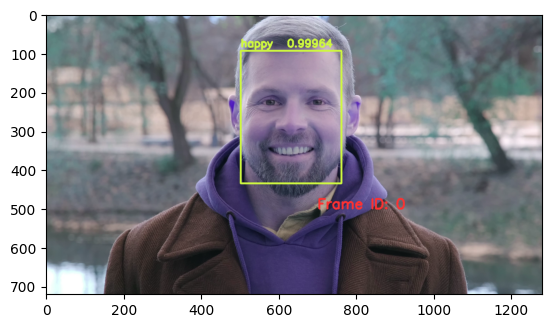

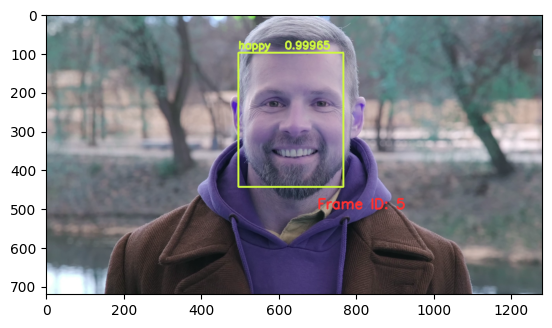

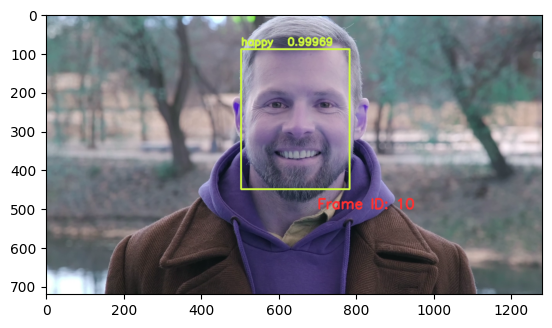

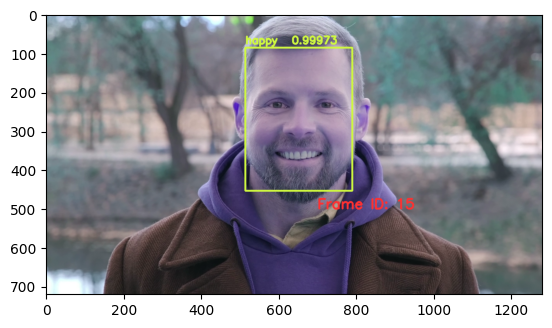

In [9]:
from ipywidgets import Video, Image
input_path = 'defhappy.mp4'
output_path = 'video.mp4'

annotate_video(response, input_path, output_path)

### Dropping an User-Defined Function (UDF)

In [10]:
cursor.query("DROP FUNCTION EmotionDetector").df()
cursor.query("DROP FUNCTION FaceDetector").df()

0
0  Function FaceDetector successfully dropped